In [94]:
using RemoteREPL
if !isdefined(Base, :task)
	task = @async serve_repl()
end

Task (failed) @0x000000000ac74f90
IOError: listen: address already in use (EADDRINUSE)
Stacktrace:
 [1] uv_error
   @ .\libuv.jl:97 [inlined]
 [2] #listen#13
   @ C:\Users\torfi\AppData\Local\Programs\julia-1.8.1\share\julia\stdlib\v1.8\Sockets\src\Sockets.jl:629 [inlined]
 [3] #listen#10
   @ C:\Users\torfi\AppData\Local\Programs\julia-1.8.1\share\julia\stdlib\v1.8\Sockets\src\Sockets.jl:622 [inlined]
 [4] #listen#12
   @ C:\Users\torfi\AppData\Local\Programs\julia-1.8.1\share\julia\stdlib\v1.8\Sockets\src\Sockets.jl:626 [inlined]
 [5] listen
   @ C:\Users\torfi\AppData\Local\Programs\julia-1.8.1\share\julia\stdlib\v1.8\Sockets\src\Sockets.jl:626 [inlined]
 [6] serve_repl(address::Sockets.IPv4, port::Int64; kws::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
   @ RemoteREPL C:\Users\torfi\.julia\packages\RemoteREPL\tVFcu\src\server.jl:241
 [7] serve_repl (repeats 2 times)
   @ C:\Users\torfi\.julia\packages\RemoteREPL\tVFcu\src\server.jl:240 [inlined]
 [8] (::var"#45#4

In [95]:
using Dates, DataFrames
using Plots, PlotThemes, Printf
theme(:dracula)
plotlyjs()
using Unitful, Latexify, Roots
using PhysicalConstants.CODATA2018: g_n

### Read and filter the Data

In [96]:
sitestr = read(download("https://www.landsvirkjun.is/rennsli-um-yfirfall-halslons"), String)
arrReg = r"\[(\[\d+,\d*[.]*\d*\][,\]])+"
nameReg = r"""\u005C"name\u005C":\u005C"(\w*\s\d*)*\u005C".\u005C"data\u005C":"""

datas = [sitestr[i] for i in findall(arrReg, sitestr)]
datas = [
	replace(i[2:end-1], "],[" => ";","," => " ")
	for i in datas
]
datas = eval.(Meta.parse.(datas))
names = [sitestr[i][end-15:end-12] for i in findall(nameReg, sitestr)];

# OH MY GOD THIS IS SO EASY!!!!!!!!
datas[1] = vcat(datas[1], zeros(length(datas[2][:,1]) - length(datas[1][:,1]),2))
datas[1][:,1] = cumsum(vcat(datas[1][1],ones(122)*diff(datas[1][:,1])[1]))
datas = hcat(datas...)
dates = [names[i] .* " Date" for i in eachindex(names)]
volsecs = [names[i] .* " volsecs" for i in eachindex(names)]
namess = Vector{String}(undef, 10)
for i in eachindex(namess)
	namess[i] = i % 2 == 0 ? volsecs[i÷2] : dates[i÷2+1]
end
dates = nothing
volsecs = nothing
datas = DataFrame(datas, namess)


,2022 Date,2022 volsecs,2021 Date,2021 volsecs,2020 Date,2020 volsecs,2019 Date
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.65663e12,0.0,1.65663e12,0.0,1.65663e12,0.0,1.65663e12
2,1.65672e12,0.0,1.65672e12,0.0,1.65672e12,0.0,1.65672e12
3,1.65681e12,0.0,1.65681e12,0.0,1.65681e12,0.0,1.65681e12
4,1.65689e12,0.0,1.65689e12,0.0,1.65689e12,0.0,1.65689e12
5,1.65698e12,0.0,1.65698e12,0.0,1.65698e12,0.0,1.65698e12
6,1.65707e12,0.0,1.65707e12,0.0,1.65707e12,0.0,1.65707e12
7,1.65715e12,0.0,1.65715e12,0.0,1.65715e12,0.0,1.65715e12
8,1.65724e12,0.0,1.65724e12,0.0,1.65724e12,0.0,1.65724e12
9,1.65732e12,0.0,1.65732e12,0.0,1.65732e12,0.0,1.65732e12


In [97]:
n = length(datas[1,:])
for i in eachindex(datas[1, 1:2:10])
	datas[!,i] = unix2datetime.(datas[!,i]./1000)
end
datas[!,2:2:n] = datas[!,2:2:n] .* 1u"m^3 * s^-1"

,2022 volsecs,2021 volsecs,2020 volsecs,2019 volsecs,2018 volsecs
,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…
1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1
2,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1
3,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1
4,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1
5,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1
6,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1
7,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1
8,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1
9,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1


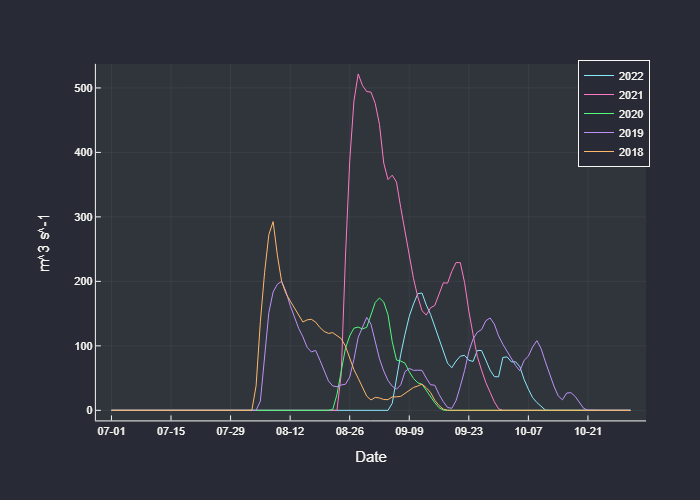

In [98]:

# I HATE DATES!
trunc(s) = s[end-4:end]
xTicks = (datas[1,1]:Day(14):datas[end,1], trunc.(string.(Date(datas[1,1]):Day(14):Date(datas[end,1]))))
p = plot(Matrix(datas[!,1:2:n]), Matrix(datas[!,2:2:n]),
	minorticks = 14,
	xticks = xTicks,
	labels = reshape(names, 1,5),
	xlabel = "Date",
)

In [99]:
latexify(:(Re = U .* D ./v), env=:eq)

L"\begin{equation}
Re = \frac{U \cdot D}{v}
\end{equation}
"

In [100]:
latexify([:(f=0.25/log10(k/3.7D+5.74/Re^0.9)^2)], env=:eq)
#=
	f = Darcy friction factor
	k = roughness factor
=#

L"\begin{equation}
\left[
\begin{array}{c}
f = \frac{0.25}{\left( \log_{10}\left( \frac{k}{3.7 \cdot D} + \frac{5.74}{Re^{0.9}} \right) \right)^{2}} \\
\end{array}
\right]
\end{equation}
"

> Swamee-Jain equation for Darcy friction factor
> -- <cite>[Swamee, P.K.; Jain, A.K. (1976). "Explicit equations for pipe-flow problems". Journal of the Hydraulics Division. 102 (5): 657–664][1]</cite>

[1]: https://doi.org/10.1061%2FJYCEAJ.0004542

In [101]:
latexify(:(h_loss = f * (L/D) * (U^2/2g)), env=:eq)
#=
	h_loss = head loss
	f = Darcy friction factor
	L = pipelength
	D = hydrolic diamiter
	U = mean velocity
	g = gravity acc
=#

L"\begin{equation}
h_{loss} = f \cdot \frac{L}{D} \cdot \frac{U^{2}}{2 \cdot g}
\end{equation}
"

> Darcy Equation 

In [102]:
latexify([:(y=2^0.25/(2sqrt(1+z^2)-z)^(3/8)*(Q*n/sqrt(S_f))^(3/8)), :(b=2y*(sqrt(1+z^2)-z)), :(t=2y*(sqrt(1+z^2)))],env=:eq) |> latexify

#=
	y = height of trapezoid
	Q = Flow rate
	z = side slope
	n = roughness coefficient
	S_f = longitudinal slope
	b = bottom width of trapezoid
	t = top width of trapezoid
=#

L"\begin{equation}
\left[
\begin{array}{c}
y = \frac{2^{0.25}}{\left( 2 \cdot \sqrt{1 + z^{2}} - z \right)^{\frac{3}{8}}} \cdot \left( \frac{Q \cdot n}{\sqrt{S_{f}}} \right)^{\frac{3}{8}} \\
b = 2 \cdot y \cdot \left( \sqrt{1 + z^{2}} - z \right) \\
t = 2 \cdot y \cdot \sqrt{1 + z^{2}} \\
\end{array}
\right]
\end{equation}
"

> ideal trapezoid equation from 
> -- <cite>[MONADJEMI, Parviz. General formulation of best hydraulic channel section. Journal of Irrigation and Drainage Engineering, 1994, vol. 120, no 1, p. 27-35.][2]</cite>

[2]: https://doi.org/10.1061/(ASCE)0733-9437(1994)120:1(27)

In [103]:
latexify(:(n = 0.012*k^(1/6)), env=:eq)

L"\begin{equation}
n = 0.012 \cdot k^{\frac{1}{6}}
\end{equation}
"


> relative surface roughness to manning coefficient conversion
> -- <cite>[Hydraulic roughness – links between Manning’s coefficient, Nikuradse’s equivalent sand roughness and bed grain size][2]</cite>

[2]: https://www.researchgate.net/publication/47529621_Hydraulic_roughness_-_links_between_Manning%27s_coefficient_Nikuradse%27s_equivalent_sand_roughness_and_bed_grain_size

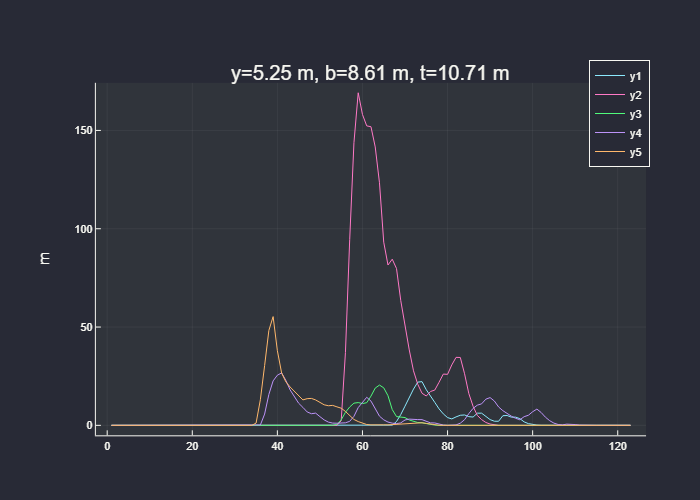

In [104]:
val(x) = (ustrip∘upreferred)(x)
function headloss(
	z = 0.2, # side slope
	k = 0.025u"mm", # Relative Surface Roughness
	S_f = 43u"m"/35u"km" # longitudinal slope
	)
	m = length(datas[1,:])
	desflow = (maximum∘Matrix)(datas[:,2:2:m])
	n = 0.012*ustrip(k)^(1/6) # manning roughness Coef

	
	# calculate best canal
	y=val(2^0.25/(2sqrt(1+z^2)-z)^(3/8)*(desflow*n/sqrt(S_f))^(3/8))u"m"
	b=2y*(sqrt(1+z^2)-z)
	t=2y*(sqrt(1+z^2))
	
	# canal crosssectional area
	A = y/2*(b+t)
	perim = b+2(hypot(t-b,y))
	L = 45_000u"m" # canal length ish
	
	U = datas[:,2:2:m] ./ A # Average velocity in canal
	D = 4A/perim # hydraulic diameter

	v = 1.52e-6u"m^2/s" # kinematic viscosity of water at 4°C
	Re = U .* D ./v # Reynolds number

	f=0.25 ./ log10.(k ./ (3.7 .* D) .+ 5.74 ./ Re .^ 0.9) .^ 2 # Darcy friction factor
	h_loss = f .* L ./ D .* U.^2 ./ 2g_n
	return (h_loss, val.([y,b,t])...)
end

h,y,b,t = headloss()
plot(Matrix(h), title=@sprintf("y=%.2f m, b=%.2f m, t=%.2f m",y,b,t))

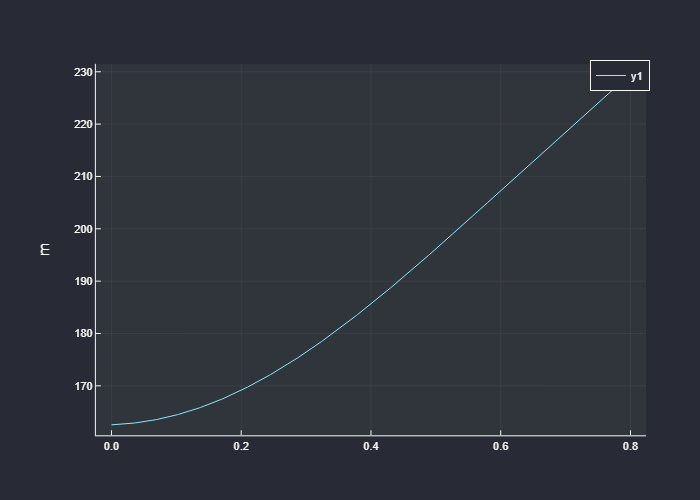

In [107]:
x = -0.0:0.001:0.8
h = maximum.(Matrix.(first.(headloss.(x))))
plot(x,h)